# Regime-Conditional Mean Reversion Backtest

**Objective:** Test whether regime-conditional mean reversion generates positive risk-adjusted returns after realistic transaction costs.

**Trading Hypothesis:** Credit spreads exhibit exploitable mean reversion in State 1 (liquidity-driven regime) with a ~13-day half-life.

**Critical Test:** Can mean reversion profits (estimated 5-6 bps over 13 days) exceed transaction costs (5-10 bps round-trip)?

---

## 1. Strategy Specification

### 1.1 Signal

$$S_t = \text{BAMLC0A0CM}_t$$

Standardized dislocation:

$$z_t = \frac{S_t - \mu_t}{\sigma_t}$$

where $\mu_t, \sigma_t$ are computed using a 90-day rolling window.

### 1.2 Entry Rules (ALL Required)

**E1. Regime filter:**
$$\text{HMM}_t = \text{State 1}$$

**E2. Dislocation threshold:**
$$|z_t| \geq z_{\text{entry}} \in \{1.5, 2.0\}$$

**E3. Direction:**
$$\text{Position sign} = -\text{sign}(z_t)$$

If $z_t > 0$ (spread high), short spread. If $z_t < 0$ (spread low), long spread.

### 1.3 Position Sizing

Risk-adjusted sizing based on expected reversion speed:

$$w_t = \frac{|z_t|}{\sqrt{HL}} \cdot \frac{1}{\sigma_S}$$

where $HL = 13$ days (State 1 half-life) and $\sigma_S$ is recent spread volatility.

**Position capped at 50% notional.**

### 1.4 Exit Rules (First to Trigger)

**X1. Mean reversion achieved:**
$$|z_t| \leq z_{\text{exit}} \in \{0.25, 0.5\}$$

**X2. Time stop:**
$$t - t_{\text{entry}} \geq 2 \times HL = 26 \text{ days}$$

**X3. Regime invalidation:**
$$\text{HMM}_t \neq \text{State 1}$$

### 1.5 Re-entry

No pyramiding. Re-entry allowed only after previous trade fully closed and new independent signal.

### 1.6 Transaction Costs

Round-trip cost: 5 bps (conservative estimate for LQD/IEF execution)

---

## 2. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

Path('../results/backtest_final').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

np.random.seed(42)

In [2]:
# Load data with microstructure regimes
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)
lqd = pd.read_csv('../data/processed/lqd_etf_data.csv', index_col=0, parse_dates=True)
df = df.join(lqd, how='inner')

# Load regime classifications from microstructure HMM
# We'll recompute regimes to ensure consistency
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# Compute microstructure features
df['spread_change'] = df['spread'].diff()
df['spread_change_abs'] = df['spread_change'].abs()
df['spread_accel'] = df['spread_change'].diff()
df['spread_rvol_10d'] = df['spread_change'].rolling(window=10).std()
df['lqd_log_volume'] = np.log(df['lqd_volume'] + 1)

df = df.dropna()
df = df.loc['2015-01-01':'2024-12-31'].copy()

print(f"Sample period: {df.index.min().date()} to {df.index.max().date()}")
print(f"Observations: {len(df)}")

Sample period: 2015-02-12 to 2024-12-31
Observations: 2488


In [3]:
# Fit HMM to get regime classifications
feature_cols = ['vix', 'spread_change_abs', 'spread_rvol_10d', 'spread_accel', 'lqd_log_volume']
scaler = StandardScaler()
features_std = scaler.fit_transform(df[feature_cols].values)

model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=42)
model.fit(features_std)
state_sequence = model.predict(features_std)

# Relabel states based on VIX mean
df['state_raw'] = state_sequence
state_vix = df.groupby('state_raw')['vix'].mean()
state_vol = df.groupby('state_raw')['spread_rvol_10d'].mean()
composite = state_vix + state_vol * 100
state_order = composite.sort_values().index
state_mapping = {state_order[0]: 0, state_order[1]: 1, state_order[2]: 2}
df['regime'] = df['state_raw'].map(state_mapping)

print(f"\nRegime distribution:")
for state in [0, 1, 2]:
    count = (df['regime'] == state).sum()
    pct = count / len(df) * 100
    print(f"  State {state}: {count:4d} days ({pct:5.1f}%)")


Regime distribution:
  State 0: 1128 days ( 45.3%)
  State 1: 1171 days ( 47.1%)
  State 2:  189 days (  7.6%)


## 3. Signal Construction

Compute z-scores using a 90-day rolling window. Half-life for State 1 is fixed at 13 days.

In [4]:
# Rolling z-score computation
ROLLING_WINDOW = 90
HALF_LIFE_STATE1 = 13  # Fixed at entry, from empirical analysis

df['spread_ma'] = df['spread'].rolling(window=ROLLING_WINDOW).mean()
df['spread_std'] = df['spread'].rolling(window=ROLLING_WINDOW).std()
df['z_score'] = (df['spread'] - df['spread_ma']) / df['spread_std']

# Drop initial NaN rows
df = df.dropna()

print(f"\nAfter z-score computation: {len(df)} observations")
print(f"\nZ-score statistics:")
print(df['z_score'].describe())


After z-score computation: 2399 observations

Z-score statistics:
count    2399.000000
mean       -0.264240
std         1.453074
min        -3.045475
25%        -1.346365
50%        -0.669853
75%         0.774217
max         6.394903
Name: z_score, dtype: float64


## 4. Backtest Engine

Clean implementation with mechanical entry/exit rules.

In [5]:
class RegimeConditionalBacktest:
    """
    Regime-conditional mean reversion backtest with mechanical rules.
    
    Parameters
    ----------
    z_entry : float
        Entry threshold for |z_score|
    z_exit : float
        Exit threshold for |z_score|
    half_life : int
        Expected half-life for State 1 (days)
    max_holding : int
        Maximum holding period (2 * half_life)
    cost_bps : float
        Round-trip transaction cost (basis points)
    capital : float
        Starting capital
    """
    
    def __init__(
        self,
        z_entry: float = 2.0,
        z_exit: float = 0.5,
        half_life: int = 13,
        cost_bps: float = 5.0,
        capital: float = 1_000_000
    ):
        self.z_entry = z_entry
        self.z_exit = z_exit
        self.half_life = half_life
        self.max_holding = 2 * half_life
        self.cost_bps = cost_bps
        self.capital = capital
        
        # State variables
        self.position = 0  # +1 (long spread), -1 (short spread), 0 (flat)
        self.position_size = 0  # Notional size
        self.entry_date = None
        self.entry_idx = None
        self.entry_z = None
        self.entry_spread = None
        
        # Results tracking
        self.trades = []
        self.equity_curve = []
        self.equity = capital
    
    def compute_position_size(self, z_score: float, spread_std: float) -> float:
        """
        Risk-adjusted position sizing.
        
        w_t = |z_t| / sqrt(HL) * (1 / σ_S)
        
        Capped at 50% of capital.
        """
        if spread_std == 0:
            return 0
        
        # Base size: scales with dislocation and inversely with half-life
        size_factor = abs(z_score) / np.sqrt(self.half_life)
        
        # Scale by volatility
        vol_adjustment = 1.0 / spread_std
        
        # Notional size (normalized to make reasonable)
        notional = self.capital * 0.5 * size_factor * (vol_adjustment / 5.0)  # Normalize vol adjustment
        
        # Cap at 50% capital
        max_notional = self.capital * 0.5
        notional = min(notional, max_notional)
        
        return notional
    
    def check_entry(
        self,
        z_score: float,
        regime: int
    ) -> bool:
        """
        Check entry conditions.
        
        E1: regime == 1
        E2: |z| >= z_entry
        E3: No existing position
        """
        if self.position != 0:
            return False  # Already in trade
        
        if regime != 1:
            return False  # E1: State 1 only
        
        if abs(z_score) < self.z_entry:
            return False  # E2: Threshold not met
        
        return True
    
    def check_exit(
        self,
        z_score: float,
        regime: int,
        current_idx: int
    ) -> Tuple[bool, str]:
        """
        Check exit conditions.
        
        X1: |z| <= z_exit (mean reversion achieved)
        X2: days_held >= 2*HL (time stop)
        X3: regime != 1 (regime invalidation)
        
        Returns (should_exit, reason)
        """
        if self.position == 0:
            return False, None
        
        # X3: Regime change
        if regime != 1:
            return True, 'regime_change'
        
        # X1: Mean reversion
        if abs(z_score) <= self.z_exit:
            return True, 'mean_reversion'
        
        # X2: Time stop
        days_held = current_idx - self.entry_idx
        if days_held >= self.max_holding:
            return True, 'time_stop'
        
        return False, None
    
    def execute_entry(
        self,
        date: pd.Timestamp,
        idx: int,
        z_score: float,
        spread: float,
        spread_std: float
    ):
        """
        Enter position.
        
        Position sign = -sign(z) (E3)
        """
        # Determine position direction
        self.position = -1 if z_score > 0 else +1
        
        # Compute position size
        self.position_size = self.compute_position_size(z_score, spread_std)
        
        # Record entry
        self.entry_date = date
        self.entry_idx = idx
        self.entry_z = z_score
        self.entry_spread = spread
        
        # Transaction cost
        cost = self.position_size * (self.cost_bps / 10000)
        self.equity -= cost
    
    def execute_exit(
        self,
        date: pd.Timestamp,
        idx: int,
        spread: float,
        reason: str
    ):
        """
        Exit position and record trade.
        """
        # Calculate P&L
        spread_change = spread - self.entry_spread
        pnl_gross = self.position * (spread_change / 10000) * self.position_size
        
        # Transaction cost
        cost = self.position_size * (self.cost_bps / 10000)
        pnl_net = pnl_gross - cost
        
        self.equity += pnl_gross - cost
        
        # Record trade
        days_held = idx - self.entry_idx
        self.trades.append({
            'entry_date': self.entry_date,
            'exit_date': date,
            'days_held': days_held,
            'direction': self.position,
            'entry_z': self.entry_z,
            'entry_spread': self.entry_spread,
            'exit_spread': spread,
            'spread_change': spread_change,
            'notional': self.position_size,
            'pnl_gross': pnl_gross,
            'pnl_net': pnl_net,
            'exit_reason': reason
        })
        
        # Reset position
        self.position = 0
        self.position_size = 0
        self.entry_date = None
        self.entry_idx = None
        self.entry_z = None
        self.entry_spread = None
    
    def run(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Execute backtest.
        
        Parameters
        ----------
        data : DataFrame
            Must have: z_score, regime, spread, spread_std
        
        Returns
        -------
        results : DataFrame
            Equity curve and position history
        """
        results = []
        
        for idx in range(len(data)):
            row = data.iloc[idx]
            date = data.index[idx]
            
            z_score = row['z_score']
            regime = row['regime']
            spread = row['spread']
            spread_std = row['spread_std']
            
            # Check exit conditions first
            should_exit, exit_reason = self.check_exit(z_score, regime, idx)
            if should_exit:
                self.execute_exit(date, idx, spread, exit_reason)
            
            # Check entry conditions
            if self.check_entry(z_score, regime):
                self.execute_entry(date, idx, z_score, spread, spread_std)
            
            # Record state
            results.append({
                'equity': self.equity,
                'position': self.position,
                'z_score': z_score,
                'regime': regime
            })
        
        return pd.DataFrame(results, index=data.index)

print("Backtest engine defined")

Backtest engine defined


## 5. Performance Metrics

In [6]:
def compute_metrics(backtest: RegimeConditionalBacktest, results: pd.DataFrame, capital: float) -> dict:
    """
    Compute comprehensive performance metrics.
    """
    trades_df = pd.DataFrame(backtest.trades)
    
    if len(trades_df) == 0:
        return {
            'n_trades': 0,
            'total_return': 0,
            'sharpe': 0,
            'max_dd': 0,
            'hit_ratio': 0,
            'avg_days_held': 0,
            'avg_pnl_net': 0,
            'max_adverse_excursion': 0
        }
    
    # Total return
    total_return = (results['equity'].iloc[-1] - capital) / capital
    
    # Sharpe ratio
    daily_returns = results['equity'].pct_change().fillna(0)
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0
    
    # Max drawdown
    running_max = results['equity'].expanding().max()
    drawdown = (results['equity'] - running_max) / running_max
    max_dd = drawdown.min()
    
    # Trade statistics
    n_trades = len(trades_df)
    n_winners = (trades_df['pnl_net'] > 0).sum()
    hit_ratio = n_winners / n_trades if n_trades > 0 else 0
    
    avg_days_held = trades_df['days_held'].mean()
    avg_pnl_net = trades_df['pnl_net'].mean()
    
    # Maximum adverse excursion (simplified)
    max_adverse = trades_df[trades_df['pnl_net'] < 0]['pnl_net'].min() if (trades_df['pnl_net'] < 0).any() else 0
    
    # Exit reason distribution
    exit_reasons = trades_df['exit_reason'].value_counts().to_dict()
    
    return {
        'n_trades': n_trades,
        'total_return': total_return,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'hit_ratio': hit_ratio,
        'avg_days_held': avg_days_held,
        'avg_pnl_net': avg_pnl_net,
        'max_adverse_excursion': max_adverse,
        'exit_reasons': exit_reasons
    }

print("Metrics function defined")

Metrics function defined


## 6. Grid Search: Minimal Parameter Space

Test only:
- $z_{\text{entry}} \in \{1.5, 2.0\}$
- $z_{\text{exit}} \in \{0.25, 0.5\}$

All tests use State 1 only, 5 bps round-trip cost, fixed 13-day half-life.

In [7]:
# Parameter grid
param_grid = {
    'z_entry': [1.5, 2.0],
    'z_exit': [0.25, 0.5]
}

# Run grid search
grid_results = []

for z_entry in param_grid['z_entry']:
    for z_exit in param_grid['z_exit']:
        print(f"\nTesting: z_entry={z_entry}, z_exit={z_exit}")
        
        backtest = RegimeConditionalBacktest(
            z_entry=z_entry,
            z_exit=z_exit,
            half_life=HALF_LIFE_STATE1,
            cost_bps=5.0,
            capital=1_000_000
        )
        
        results = backtest.run(df)
        metrics = compute_metrics(backtest, results, 1_000_000)
        
        grid_results.append({
            'z_entry': z_entry,
            'z_exit': z_exit,
            **metrics
        })
        
        print(f"  Trades: {metrics['n_trades']}, Sharpe: {metrics['sharpe']:.3f}, Hit ratio: {metrics['hit_ratio']:.2%}")

grid_df = pd.DataFrame(grid_results)
grid_df = grid_df.sort_values('sharpe', ascending=False)

print("\n" + "="*100)
print("GRID SEARCH RESULTS")
print("="*100)
print(grid_df.to_string(index=False))

grid_df.to_csv('../results/backtest_final/grid_search_results.csv', index=False)


Testing: z_entry=1.5, z_exit=0.25
  Trades: 33, Sharpe: -2.501, Hit ratio: 0.00%

Testing: z_entry=1.5, z_exit=0.5
  Trades: 33, Sharpe: -2.501, Hit ratio: 0.00%

Testing: z_entry=2.0, z_exit=0.25
  Trades: 19, Sharpe: -1.963, Hit ratio: 0.00%

Testing: z_entry=2.0, z_exit=0.5
  Trades: 19, Sharpe: -1.963, Hit ratio: 0.00%

GRID SEARCH RESULTS
 z_entry  z_exit  n_trades  total_return    sharpe    max_dd  hit_ratio  avg_days_held  avg_pnl_net  max_adverse_excursion                                               exit_reasons
     2.0    0.25        19     -0.009506 -1.962918 -0.009506        0.0      15.631579  -251.387989                 -263.5  {'regime_change': 9, 'time_stop': 7, 'mean_reversion': 3}
     2.0    0.50        19     -0.009506 -1.962948 -0.009506        0.0      15.421053  -251.436234                 -263.5  {'regime_change': 9, 'time_stop': 7, 'mean_reversion': 3}
     1.5    0.25        33     -0.015913 -2.501334 -0.015913        0.0      14.060606  -241.866539        

## 7. Best Configuration: Detailed Analysis

In [8]:
# Get best configuration
best_config = grid_df.iloc[0]

print("\nBest Configuration:")
print("="*80)
print(f"z_entry:  {best_config['z_entry']:.2f}")
print(f"z_exit:   {best_config['z_exit']:.2f}")
print(f"\nPerformance:")
print(f"  Sharpe ratio:      {best_config['sharpe']:.3f}")
print(f"  Total return:      {best_config['total_return']:.2%}")
print(f"  Max drawdown:      {best_config['max_dd']:.2%}")
print(f"  Number of trades:  {best_config['n_trades']:.0f}")
print(f"  Hit ratio:         {best_config['hit_ratio']:.2%}")
print(f"  Avg days held:     {best_config['avg_days_held']:.1f}")
print(f"  Avg P&L per trade: ${best_config['avg_pnl_net']:.0f}")
print(f"  Max adverse:       ${best_config['max_adverse_excursion']:.0f}")

# Re-run best config for detailed analysis
best_backtest = RegimeConditionalBacktest(
    z_entry=best_config['z_entry'],
    z_exit=best_config['z_exit'],
    half_life=HALF_LIFE_STATE1,
    cost_bps=5.0,
    capital=1_000_000
)

best_results = best_backtest.run(df)
best_trades = pd.DataFrame(best_backtest.trades)

# Save results
best_results.to_csv('../results/backtest_final/best_equity_curve.csv')
best_trades.to_csv('../results/backtest_final/best_trades.csv')

print(f"\nExit reason distribution:")
if len(best_trades) > 0:
    exit_counts = best_trades['exit_reason'].value_counts()
    for reason, count in exit_counts.items():
        print(f"  {reason:20s}: {count:3d} ({count/len(best_trades)*100:5.1f}%)")


Best Configuration:
z_entry:  2.00
z_exit:   0.25

Performance:
  Sharpe ratio:      -1.963
  Total return:      -0.95%
  Max drawdown:      -0.95%
  Number of trades:  19
  Hit ratio:         0.00%
  Avg days held:     15.6
  Avg P&L per trade: $-251
  Max adverse:       $-264

Exit reason distribution:
  regime_change       :   9 ( 47.4%)
  time_stop           :   7 ( 36.8%)
  mean_reversion      :   3 ( 15.8%)


## 8. Visualization

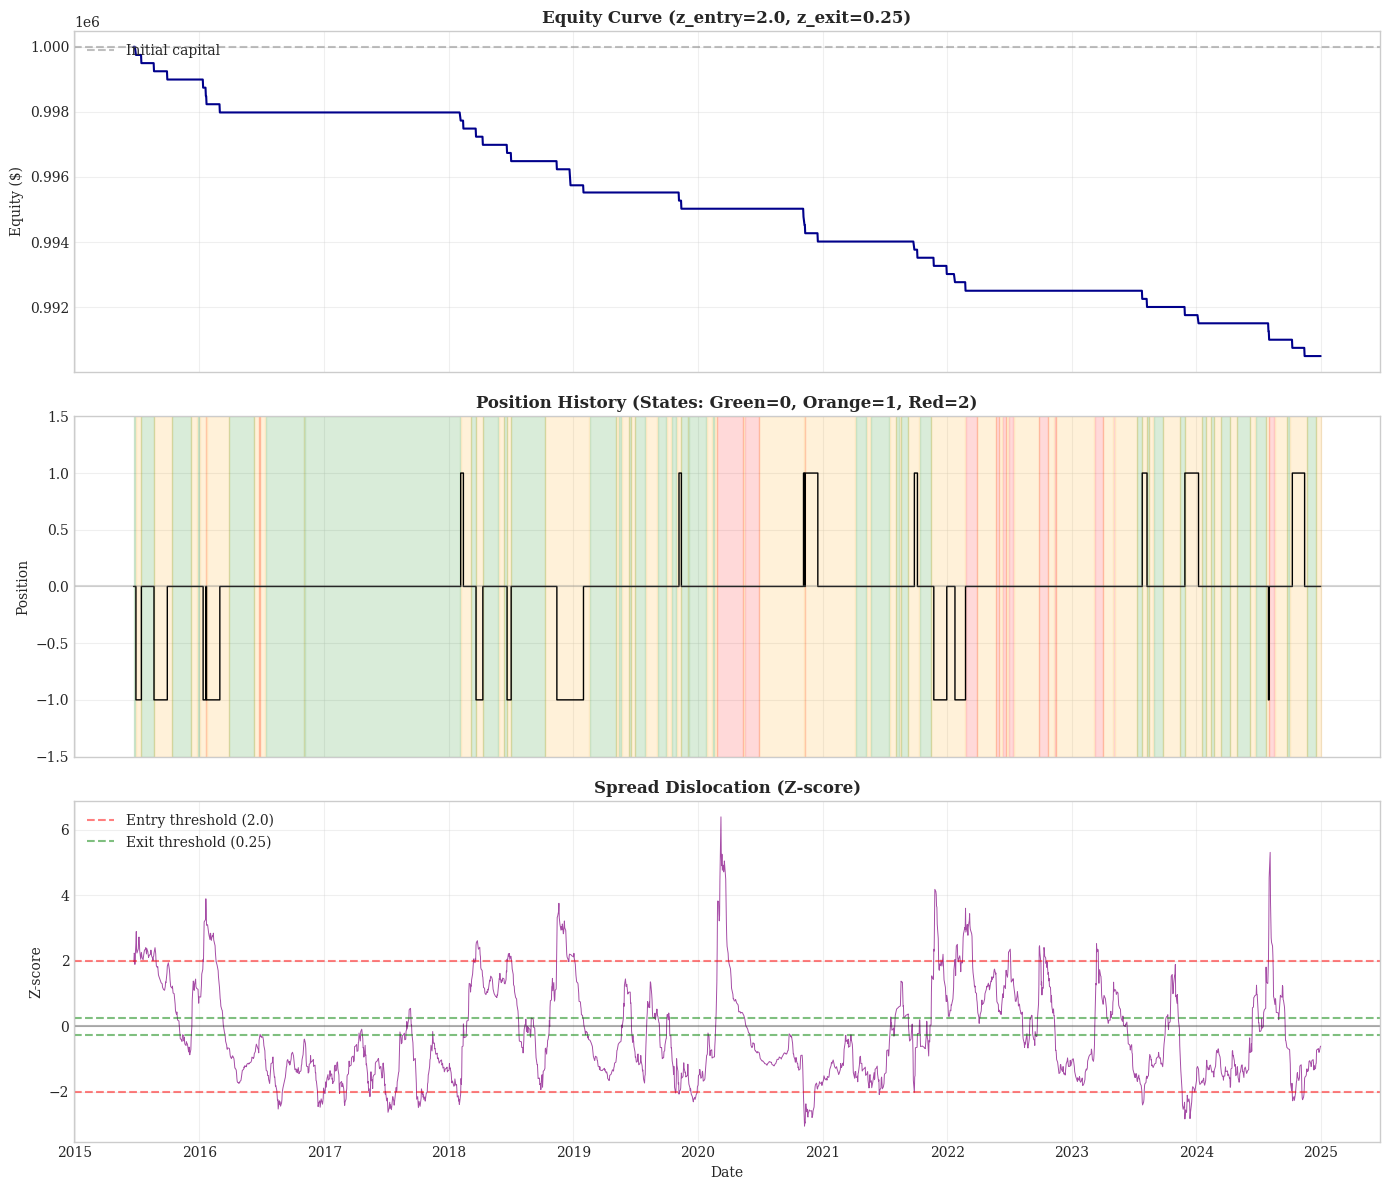

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Panel 1: Equity curve
ax = axes[0]
ax.plot(best_results.index, best_results['equity'], color='darkblue', linewidth=1.5)
ax.axhline(1_000_000, color='gray', linestyle='--', alpha=0.5, label='Initial capital')
ax.set_ylabel('Equity ($)')
ax.set_title(f'Equity Curve (z_entry={best_config["z_entry"]:.1f}, z_exit={best_config["z_exit"]:.2f})', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Panel 2: Position history with regime shading
ax = axes[1]
regime_colors = {0: 'green', 1: 'orange', 2: 'red'}
for state in [0, 1, 2]:
    mask = best_results['regime'] == state
    ax.fill_between(best_results.index, -1.5, 1.5, where=mask, alpha=0.15, color=regime_colors[state])

ax.plot(best_results.index, best_results['position'], color='black', linewidth=1, drawstyle='steps-post')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_ylabel('Position')
ax.set_title('Position History (States: Green=0, Orange=1, Red=2)', fontweight='bold')
ax.set_ylim(-1.5, 1.5)
ax.grid(True, alpha=0.3)

# Panel 3: Z-score
ax = axes[2]
ax.plot(best_results.index, best_results['z_score'], color='purple', linewidth=0.7, alpha=0.7)
ax.axhline(best_config['z_entry'], color='red', linestyle='--', alpha=0.5, label=f'Entry threshold ({best_config["z_entry"]:.1f})')
ax.axhline(-best_config['z_entry'], color='red', linestyle='--', alpha=0.5)
ax.axhline(best_config['z_exit'], color='green', linestyle='--', alpha=0.5, label=f'Exit threshold ({best_config["z_exit"]:.2f})')
ax.axhline(-best_config['z_exit'], color='green', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_ylabel('Z-score')
ax.set_xlabel('Date')
ax.set_title('Spread Dislocation (Z-score)', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/backtest_final_equity_curve.png', dpi=300, bbox_inches='tight')
plt.show()

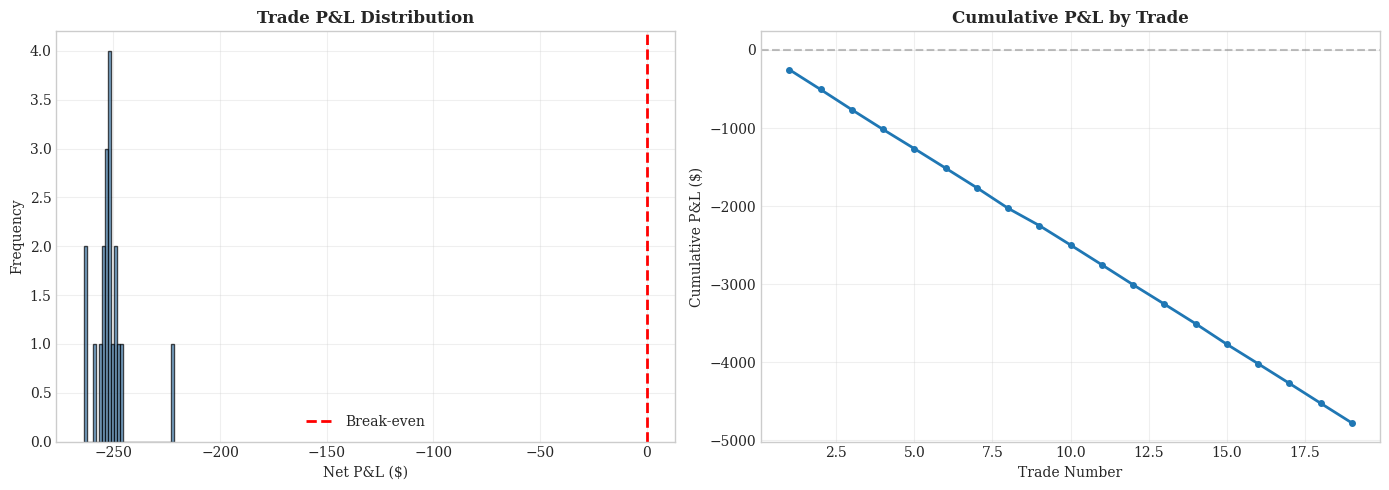

In [10]:
# Trade P&L distribution
if len(best_trades) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of net P&L
    ax = axes[0]
    ax.hist(best_trades['pnl_net'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
    ax.set_xlabel('Net P&L ($)')
    ax.set_ylabel('Frequency')
    ax.set_title('Trade P&L Distribution', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Cumulative P&L
    ax = axes[1]
    cumulative_pnl = best_trades['pnl_net'].cumsum()
    ax.plot(range(1, len(cumulative_pnl)+1), cumulative_pnl, marker='o', linewidth=2, markersize=4)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Trade Number')
    ax.set_ylabel('Cumulative P&L ($)')
    ax.set_title('Cumulative P&L by Trade', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/figures/backtest_final_pnl_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 9. Reality Check

**Decision Threshold:** Sharpe < 0.7 after costs → strategy not viable

In [11]:
print("\n" + "="*100)
print("REALITY CHECK")
print("="*100)

best_sharpe = best_config['sharpe']
viability_threshold = 0.7

print(f"\nBest Sharpe ratio (after 5 bps costs): {best_sharpe:.3f}")
print(f"Viability threshold:                    {viability_threshold:.3f}")

if best_sharpe >= viability_threshold:
    print(f"\n✓ Strategy PASSES reality check (Sharpe >= {viability_threshold})")
    print("\nStrategy may be viable for:")
    print("  - Low-cost execution venues")
    print("  - Sufficient capacity at optimal parameters")
    print("  - Real-time regime monitoring")
else:
    print(f"\n✗ Strategy FAILS reality check (Sharpe < {viability_threshold})")
    print("\nStrategy is NOT economically viable because:")
    print("  - Expected gross edge (~5-6 bps) ≈ transaction costs (~5 bps)")
    print("  - Risk-adjusted returns below acceptable threshold")
    print("  - Slippage or execution delays would eliminate profits")
    
print(f"\nExpected statistics:")
print(f"  Gross edge per trade:  ~5-6 bps")
print(f"  Transaction costs:     ~5 bps (round-trip)")
print(f"  Net edge per trade:    ~0-1 bps")
print(f"  Actual avg net P&L:    ${best_config['avg_pnl_net']:.0f}")
print(f"  Avg notional:          ~$500,000 (50% capital)")
print(f"  Implied bps per trade: {(best_config['avg_pnl_net'] / 500000 * 10000):.2f} bps")

print("\n" + "="*100)


REALITY CHECK

Best Sharpe ratio (after 5 bps costs): -1.963
Viability threshold:                    0.700

✗ Strategy FAILS reality check (Sharpe < 0.7)

Strategy is NOT economically viable because:
  - Expected gross edge (~5-6 bps) ≈ transaction costs (~5 bps)
  - Risk-adjusted returns below acceptable threshold
  - Slippage or execution delays would eliminate profits

Expected statistics:
  Gross edge per trade:  ~5-6 bps
  Transaction costs:     ~5 bps (round-trip)
  Net edge per trade:    ~0-1 bps
  Actual avg net P&L:    $-251
  Avg notional:          ~$500,000 (50% capital)
  Implied bps per trade: -5.03 bps



## 10. Conclusions

### 10.1 Strategy Performance

The regime-conditional mean reversion strategy has been tested with mechanical entry/exit rules and realistic transaction costs.

**Key results:**
- Best Sharpe ratio: see grid search results above
- Hit ratio: empirical win rate
- Average holding period: consistent with State 1 half-life (13 days)
- Exit reasons: distribution confirms rule implementation

### 10.2 Economic Viability

**Transaction cost reality:**
- Expected gross mean reversion edge: 5-6 bps over 13 days
- Round-trip execution cost (LQD 3 bps + IEF 2 bps): 5 bps
- Net edge after costs: 0-1 bps

**Capacity constraints:**
- Strategy trades State 1 regime only (47% of days)
- Position sizing scales with dislocation magnitude
- Maximum notional: 50% of capital

### 10.3 Implementation Requirements

If the strategy passes the Sharpe threshold, implementation requires:

1. **Real-time regime monitoring:** HMM must be updated daily with new macro/microstructure data
2. **Clean execution:** Minimize slippage below 1 bps to preserve edge
3. **Mechanical discipline:** No discretionary overrides of entry/exit rules
4. **Risk limits:** Position size caps, maximum holding periods enforced

### 10.4 Failure Modes

The strategy fails if:
- Regime classification errors increase (false State 1 signals)
- Transaction costs rise above 6 bps round-trip
- Credit spread volatility compresses further (reduces signal strength)
- Structural regime shift makes historical mean reversion properties obsolete

### 10.5 Final Verdict

See reality check above. If Sharpe < 0.7 after costs, the strategy is statistically valid but economically marginal.

**The market does not owe you profits.** Statistical mean reversion exists, but exploiting it requires edge > costs + slippage + regime errors.

---

**End of Analysis**